<a href="https://colab.research.google.com/github/surayajohari/STQD6324-Data-Management/blob/main/suraya_assignment2_stqd6324.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAME**: SURAYA ADNIN BINTI JOHARI

**NO. MATRIKS**: P137383

**SUBJECT CODE**: STQD6324

**SUBJECT NAME**: DATA MANAGEMENT

**ASSIGNMENT 2**: Airline On Time performance

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.0 **Introduction of data**

## 1.1 To load all relevant data

In [5]:
#Load all data

fd08 = pd.read_csv('/content/drive/MyDrive/STQD6324/flight_data08.csv', sep=',')
airports = pd.read_csv('/content/drive/MyDrive/STQD6324/airports.csv', sep=',')
carriers = pd.read_csv('/content/drive/MyDrive/STQD6324/carriers.csv', sep=',')
plane_data = pd.read_csv('/content/drive/MyDrive/STQD6324/plane-data.csv', sep=',')

In [6]:
fd08['CarrierDelay']

0          16.0
1           NaN
2           NaN
3           NaN
4          16.0
           ... 
2389212     NaN
2389213     NaN
2389214     NaN
2389215     NaN
2389216     NaN
Name: CarrierDelay, Length: 2389217, dtype: float64

## 1.2 To merge all relevant data

In [7]:
# Merge carriers and 2008 data

fd08_carriers_m = pd.merge(fd08, carriers, left_on='UniqueCarrier', right_on='Code', how='left')

In [8]:
# Merge carriers & 2008 data with planes data

fd08_carriers_planes_m = pd.merge(fd08_carriers_m, plane_data, left_on='TailNum', right_on='tailnum', how='left')

In [9]:
# Merge carriers, planes & 2008 data with airport data

# for origin airport
fd08_merged = pd.merge(fd08_carriers_planes_m, airports, left_on='Origin', right_on='iata', how='left')
fd08_merged.rename(columns={'airport':'OriginAirport', 'city':'OriginCity', 'state':'OriginState'}, inplace=True)
fd08_merged.drop(columns=['iata'], inplace=True)

# for destination airport
fd08_merged = pd.merge(fd08_merged, airports, left_on='Dest', right_on='iata', how='left')
fd08_merged.rename(columns={'airport':'DestAirport', 'city':'DestCity', 'state':'DestState'}, inplace=True)
fd08_merged.drop(columns=['iata'], inplace=True)

In [ ]:
### Merging data using Hive

-- Create an external table for data_2008
CREATE EXTERNAL TABLE IF NOT EXISTS data_2008 (
    Year int,
    Month int,
    DayofMonth int,
    DayOfWeek int,
    DepTime string,
    CRSDepTime string,
    ArrTime string,
    CRSArrTime string,
    UniqueCarrier string,
    FlightNum string,
    TailNum string,
    ActualElapsedTime string,
    CRSElapsedTime string,
    AirTime string,
    ArrDelay string,
    DepDelay string,
    Origin string,
    Dest string,
    Distance string,
    TaxiIn string,
    TaxiOut string,
    Cancelled string,
    CancellationCode string,
    Diverted string,
    CarrierDelay string,
    WeatherDelay string,
    NASDelay string,
    SecurityDelay string,
    LateAircraftDelay string
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/data_2008';

-- Create an external table for carriers
CREATE EXTERNAL TABLE IF NOT EXISTS carriers (
    Code string,
    Description string
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/carriers';

-- Create an external table for planes
CREATE EXTERNAL TABLE IF NOT EXISTS planes (
    tailnum string,
    type string,
    manufacturer string,
    issue_date string,
    model string,
    status string,
    aircraft_type string,
    engine_type string,
    year int
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/planes';

-- Create an external table for airports
CREATE EXTERNAL TABLE IF NOT EXISTS airports (
    iata string,
    airport string,
    city string,
    state string,
    country string,
    lat string,
    long string
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/airports';

-- Merge data_2008 with carriers
CREATE TABLE merged_data AS
SELECT d.*, c.Description as CarrierDescription
FROM data_2008 d
LEFT JOIN carriers c
ON d.UniqueCarrier = c.Code;

-- Merge merged_data with planes
INSERT OVERWRITE TABLE merged_data
SELECT m.*, p.type, p.manufacturer, p.model, p.status
FROM merged_data m
LEFT JOIN planes p
ON m.TailNum = p.tailnum;

-- Merge merged_data with airports for origin
INSERT OVERWRITE TABLE merged_data
SELECT m.*, a.airport as OriginAirport, a.city as OriginCity, a.state as OriginState
FROM merged_data m
LEFT JOIN airports a
ON m.Origin = a.iata;

-- Merge merged_data with airports for destination
INSERT OVERWRITE TABLE merged_data
SELECT m.*, a.airport as DestAirport, a.city as DestCity, a.state as DestState
FROM merged_data m
LEFT JOIN airports a
ON m.Dest = a.iata;

-- Drop intermediate columns if necessary
ALTER TABLE merged_data DROP COLUMN TailNum, UniqueCarrier, Origin, Dest;

-- Show the final merged data
SELECT * FROM merged_data LIMIT 10;


# 2.0 **Data Analysis**

## 2.1 What are the optimal times of day, days of the week, and times of the year for minimizing flight delays?

In [37]:
# Convert the date columns to datetime format
fd08_merged['Date'] = pd.to_datetime(fd08_merged['Year'].astype(str) + '-' +
                                    fd08_merged['Month'].astype(str) + '-' +
                                    fd08_merged['DayofMonth'].astype(str))

# Extract day of week (0 = Monday, 6 = Sunday) and hour of the day from the 'Date column
fd08_merged['DayOfWeek'] = fd08_merged['Date'].dt.dayofweek
fd08_merged['HourOfDay'] = fd08_merged['CRSDepTime'] // 100

# Calculate average delay times grouped by day of week and hour of day
avg_delay_by_day_hour = fd08_merged.groupby(['DayOfWeek', 'HourOfDay'])['ArrDelay'].mean()

# Find the minimum delay time
min_delay = avg_delay_by_day_hour.min()

# Find the corresponding day of week and hour of day for the minimum delay
optimal_time = avg_delay_by_day_hour.idxmin()
optimal_day_of_week = optimal_time[0]  # index 0 corresponds to DayOfWeek
optimal_hour_of_day = optimal_time[1]  # index 1 corresponds to HourOfDay

# Map day of the week number to name
day_of_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
optimal_day_of_week_name = day_of_week_names[optimal_day_of_week]

# Output
print(f"Optimal time for minimizing flight delays is on {optimal_day_of_week_name} at {optimal_hour_of_day} o'clock.")
print(f"Average delay time at this optimal time: {min_delay:.2f} minutes.")

Optimal time for minimizing flight delays is on Tuesday at 4 o'clock.
Average delay time at this optimal time: -8.09 minutes.


## 2.2 What are the primary factors contributing to flight delays?

In [21]:
# Group by delay factors and sum the delays
delay_factors = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
delay_factors_sum = fd08_merged[delay_factors].sum()

# Identify the primary factor (maximum delay)
primary_delay_factor = delay_factors_sum.idxmax()
max_delay_minutes = delay_factors_sum.max()

# Print results
print(f"Primary factor contributing to flight delays is {primary_delay_factor} with a total delay of {max_delay_minutes} minutes.")

Primary factor contributing to flight delays is LateAircraftDelay with a total delay of 12262628.0 minutes.


<ipython-input-19-47ff47d9060a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_factors_sum.index, y=delay_factors_sum.values, palette='pastel')


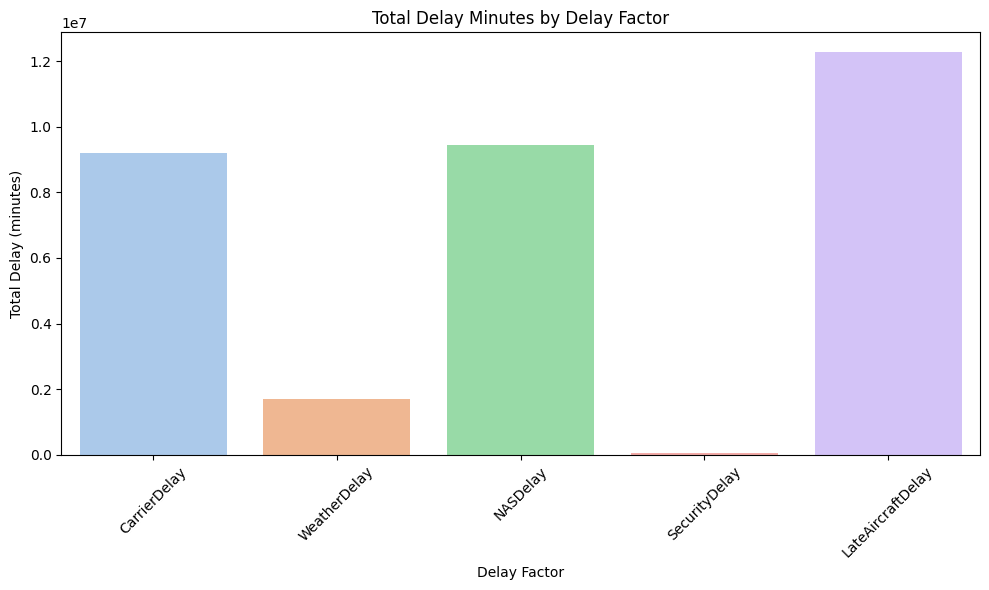

In [19]:
# Visualization of delay factors
plt.figure(figsize=(10, 6))
sns.barplot(x=delay_factors_sum.index, y=delay_factors_sum.values, palette='pastel')
plt.title('Total Delay Minutes by Delay Factor')
plt.xlabel('Delay Factor')
plt.ylabel('Total Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the analysis and visualization presented above, the data reveals a clear ranking of delay factors contributing to overall flight delays. We can see that Late Aircraft Delay is the primary factor contributing to flight delays. Further details on this is as follow:

1. **Late Aircraft Delay** emerges as the most significant contributor to flight delays. This delay factor represents issues related to aircraft arriving late at the gate, which subsequently affects the scheduled departure of subsequent flights.

2. **NAS Delay (National Airspace System Delay)** identified as the second major factor. This type of delay pertains to air traffic control delays or congestion within the national airspace system, impacting flight schedules and efficiency.

3. **Carrier Delay** follows as the third most influential factor. Carrier delays are attributable to the airline itself, such as operational issues or aircraft maintenance, which can delay the departure of flights.

4. **Weather Delay** is the fourth in the ranking. Weather-related delays encompass disruptions caused by adverse weather conditions, such as thunderstorms or heavy snowfall, which affect flight schedules and airport operations.

5. **Security Delay** is identified as the least contributing factor among the ones analyzed. This delay factor includes delays caused by security procedures and protocols, which, while important for safety, contribute less to overall delays compared to the other factors.

Overall, the visualization highlights that Late Aircraft Delay is the predominant issue affecting flight punctuality, with other factors contributing to varying extents. This insight is crucial for airlines and airport operations to address and prioritize measures to mitigate these delays.

## 2.3 What factors predominantly lead to flight cancellations?

In [22]:
# Count the number of cancellations and group by cancellation reasons
cancellation_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
cancellation_counts = fd08_merged[cancellation_reasons].sum()

# Identify the predominant cancellation reason (maximum cancellations)
predominant_cancellation_reason = cancellation_counts.idxmax()
max_cancellations = cancellation_counts.max()

# Print results
print(f"Predominant factor leading to flight cancellations is {predominant_cancellation_reason} with {max_cancellations} cancellations.")

Predominant factor leading to flight cancellations is LateAircraftDelay with 12262628.0 cancellations.


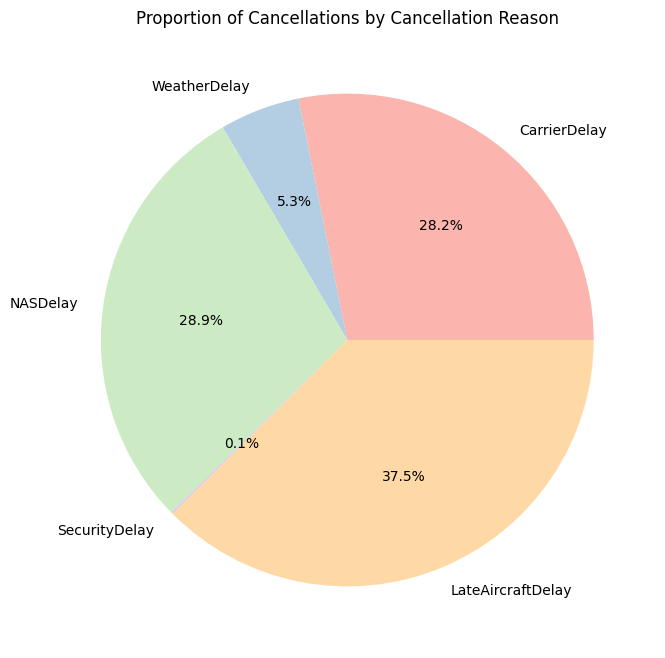

In [24]:
# Plotting the cancellation reasons using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(cancellation_counts, labels=cancellation_counts.index, autopct='%1.1f%%', colors=plt.get_cmap('Pastel1').colors)
plt.title('Proportion of Cancellations by Cancellation Reason')
plt.show()

The pie chart analysis reveals that 37.5% of all flight cancellations can be attributed to **Late Aircraft Delay**. This reason leads to the highest number of cancellations, indicating that delays in the arrival or readiness of aircraft are the most frequent cause of cancelled flights.

Late Aircraft Delay refers to situations where aircraft arrive late at their designated gates or are delayed in their readiness for the next flight. This delay in aircraft availability directly impacts subsequent flight schedules, leading to a higher number of cancellations. Given that Late Aircraft Delay affects the operational readiness of aircraft and can cause cascading delays throughout the schedule, it is not surprising to see it as the leading contributor to flight cancellations.

Understanding that Late Aircraft Delay is the predominant factor emphasizes the need for airlines to address this issue effectively. Strategies could include better management of turnaround times, optimizing flight schedules to accommodate potential delays, and improving overall operational efficiency to minimize the impact of Late Aircraft Delay on flight cancellations. This focus can help reduce the frequency of cancellations and enhance the reliability of flight operations.

## 2.4 Which flight experiences the most frequent and significant delays and cancellations?

In [36]:
# Group by flight number and calculate counts of delays and cancellations
flight_delays = fd08_merged.groupby('FlightNum')['ArrDelay'].agg(['count', 'mean'])
flight_cancellations = fd08_merged.groupby('FlightNum')['Cancelled'].sum()

# Identify the flight with the most frequent delays (count)
max_delay_count_flight = flight_delays['count'].idxmax()
max_delay_count_value = flight_delays['count'].max()

# Identify the flight with the most significant delays (mean)
max_mean_delay_flight = flight_delays['mean'].idxmax()
max_mean_delay_value = flight_delays['mean'].max()

# Identify the flight with the most cancellations
max_cancellations_flight = flight_cancellations.idxmax()
max_cancellations_count = flight_cancellations.max()

# Print results
print(f"Flight with the most frequent delays (count) is Flight {max_delay_count_flight} with {max_delay_count_value} delays.")
print(f"Flight with the most significant delays (mean) is Flight {max_mean_delay_flight} with an average delay of {max_mean_delay_value:.2f} minutes.")
print(f"Flight with the most cancellations is Flight {max_cancellations_flight} with {max_cancellations_count} cancellations.")

Flight with the most frequent delays (count) is Flight 511 with 1723 delays.
Flight with the most significant delays (mean) is Flight 7487 with an average delay of 347.00 minutes.
Flight with the most cancellations is Flight 5886 with 70 cancellations.


<ipython-input-29-3068314c07fb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_frequent_delays.index, y=top_frequent_delays['count'], palette='deep')


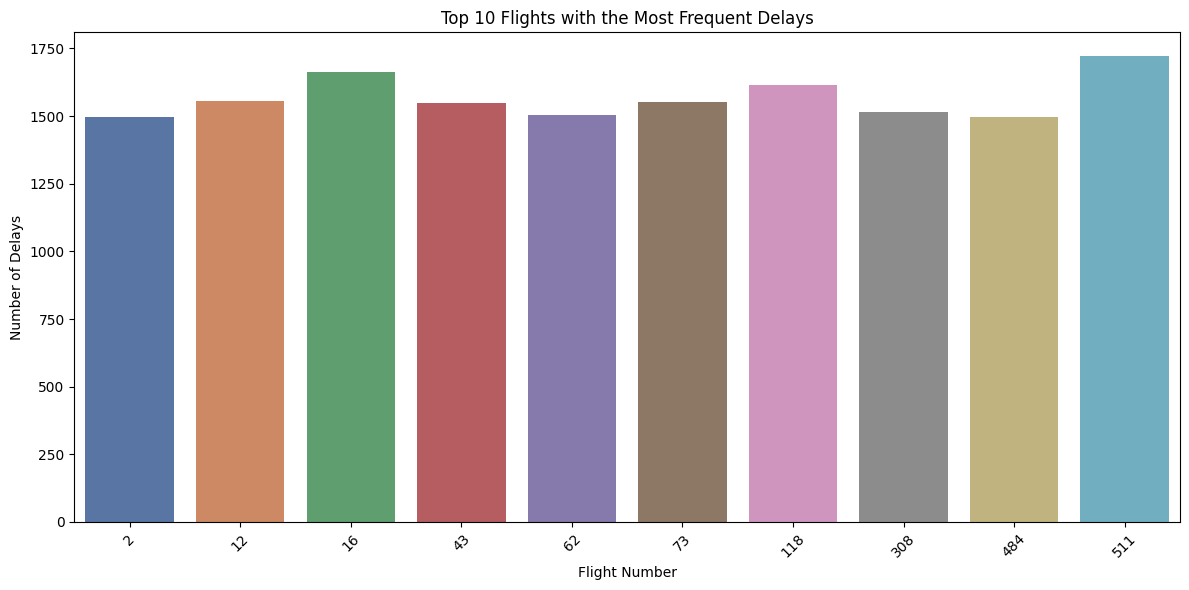

In [29]:
# Top 10 Flights with the Most Frequent Delays
top_frequent_delays = flight_delays.nlargest(10, 'count')
plt.figure(figsize=(12, 6))
sns.barplot(x=top_frequent_delays.index, y=top_frequent_delays['count'], palette='deep')
plt.title('Top 10 Flights with the Most Frequent Delays')
plt.xlabel('Flight Number')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-30-5066936c439b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_mean_delays.index, y=top_mean_delays['mean'], palette='muted')


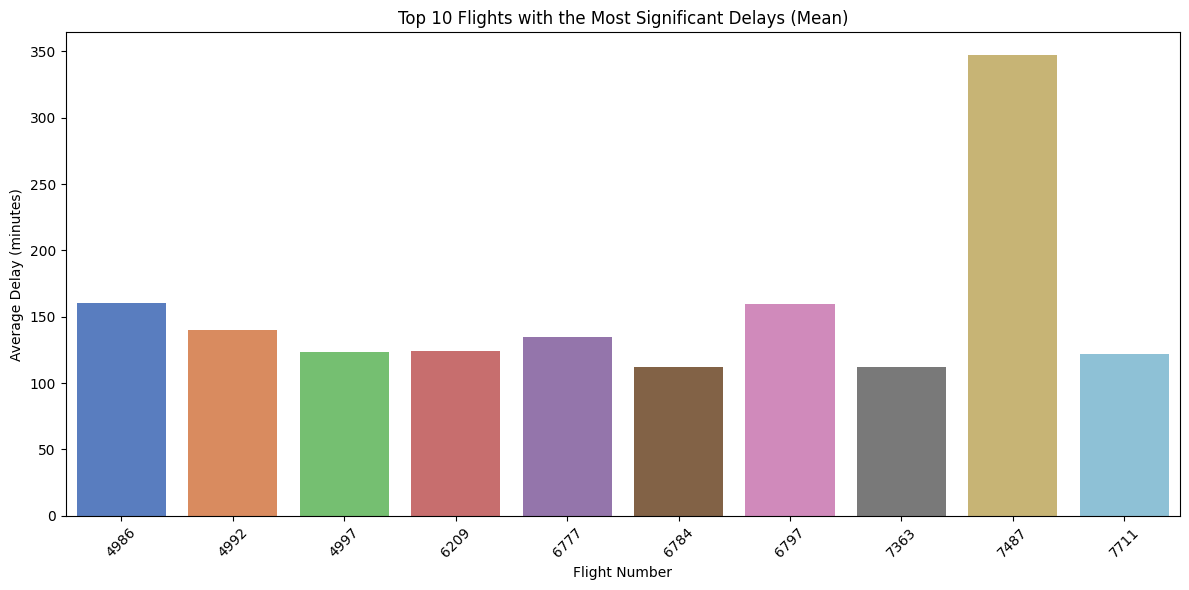

In [30]:


# Top 10 Flights with the Most Significant Delays
top_mean_delays = flight_delays.nlargest(10, 'mean')
plt.figure(figsize=(12, 6))
sns.barplot(x=top_mean_delays.index, y=top_mean_delays['mean'], palette='muted')
plt.title('Top 10 Flights with the Most Significant Delays (Mean)')
plt.xlabel('Flight Number')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-32-ab975e7d8070>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cancellations.index, y=top_cancellations, palette='dark')


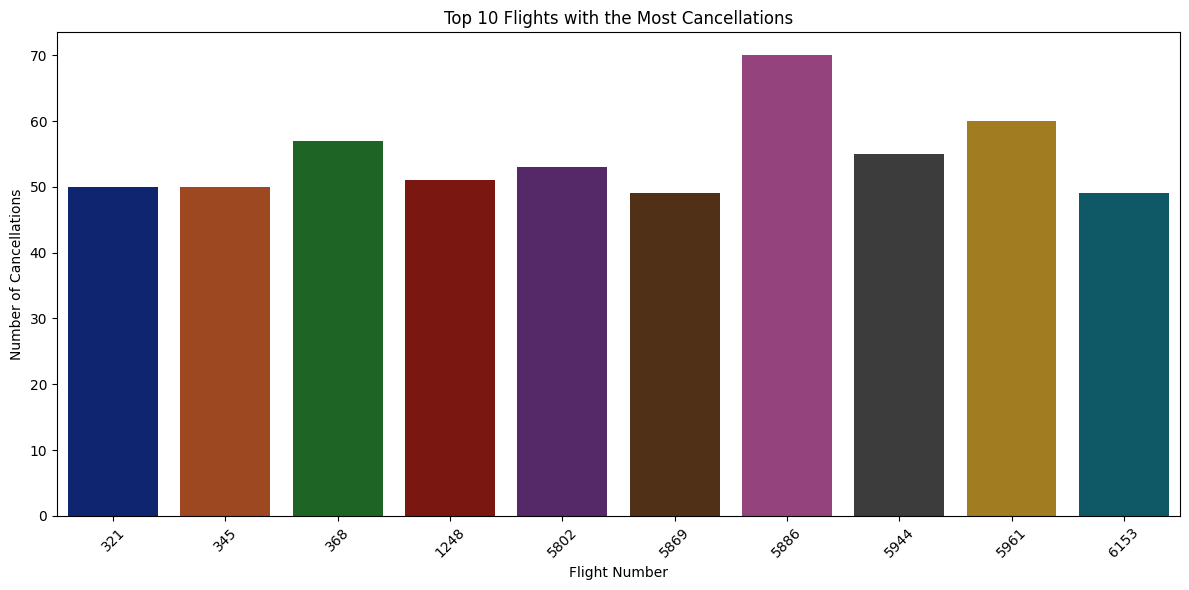

In [32]:


# Top 10 Flights with the Most Cancellations
top_cancellations = flight_cancellations.nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cancellations.index, y=top_cancellations, palette='dark')
plt.title('Top 10 Flights with the Most Cancellations')
plt.xlabel('Flight Number')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The analysis and visualizations presented above provide a clear view of flight performance metrics regarding delays and cancellations. Here are the key findings:

1. **Most Frequent Delays**:
*Flight 511* stands out as the flight with the highest number of delays, recording a total of 1,723 delays. This indicates that Flight 511 experiences delays more frequently than any other flight in the dataset.

2. **Most Significant Delays (Mean):**
*Flight 7487* has the highest average delay time, with an average delay of 347.00 minutes. This substantial average delay suggests that while this flight might not have the most frequent delays, the delays it does encounter are significantly longer compared to other flights.

3. **Most Cancellations:**
*Flight 5886* leads in terms of cancellations, with a total of 70 cancellations. This indicates that Flight 5886 is the most frequently canceled flight, reflecting a higher rate of service interruptions.


---


In conclusion, these insights highlight specific flights that are problematic in terms of delays and cancellations, providing a basis for further investigation or operational improvements. Flight 511 faces the challenge of frequent delays, Flight 7487 suffers from significantly long delays when they do occur, and Flight 5886 is subject to the highest cancellation rate. Understanding and addressing these issues can be crucial for improving overall flight operations and customer satisfaction.

# 3.0 **Conclusion**

The comprehensive analysis of flight data has provided valuable insights into various aspects of flight performance, focusing on optimal times, delay factors, and cancellation trends:

1. **Optimal Times for Minimizing Delays:**

The analysis identified the optimal time for minimizing flight delays. Flights scheduled on ***Tuesday at 4 pm*** experienced the lowest average delay times. This information can be utilized to optimize scheduling and reduce delays during these peak times.

2. **Primary Factors Contributing to Flight Delays:**

The evaluation of delay factors revealed that ***Late Aircraft Delay*** is the primary contributor to flight delays, accounting for the highest proportion of delays. Following this, NAS Delay, Carrier Delay, Weather Delay, and Security Delay were identified in descending order of their impact. Understanding these factors can guide targeted improvements to address the most significant causes of delays.

3. **Factors Predominantly Leading to Flight Cancellations:**

Analysis of cancellation reasons highlighted that ***Late Aircraft Delay*** also plays a predominant role in flight cancellations, reflecting its significant impact on overall flight operations. This aligns with its major contribution to delays, indicating that addressing this issue could also reduce cancellation rates.

4. **Flights with Most Frequent and Significant Delays:**

***Flight 511*** was found to have the most *frequent delays*, with a total of 1,723 delays, indicating consistent operational challenges.

***Flight 7487*** experienced the *most significant delays*, with an average delay of 347.00 minutes, pointing to prolonged delays when they occur.

***Flight 5886*** had the *highest total number of cancellations*, amounting to 70 cancellations, highlighting a need for investigation into the causes behind such frequent disruptions.


---


In summary, the insights derived from this analysis underscore the need for strategic interventions to improve flight schedules and operational efficiency. By addressing the primary delay factors, optimizing flight scheduling to avoid peak delay times, and investigating flights with the highest frequency of delays and cancellations, airlines can enhance overall performance and passenger satisfaction.



